## Test Project &mdash; Asset Management

**Class-Based Implementation of Mean-Variance Portfolios**

Implement a class that does the following:

* uses the data set `https://hilpisch.com/indices_eikon_eod_data.csv`
* allows to define the investable universe (= set of instruments to be used)
* assumes that 100% of a capital base is to be invested (normalized portfolios)
* allows to define whether short sales are allowed or not
* allows to define a maximum (in negative %) for any short position (say, `-0.1` for "10% short")
* calculates for an arbitraty portfolio composition (in line with the before assumptions/constraints) the expected return and the volatility of the portfolio
* simulates random portfolio compositions including risk-return statistics and allows for the visualization of these statistics
* uses optimization techniques with freely defined bounds (say, "every asset shall have a minimum allocation of 5%") to ...
    * ... derive the minimum risk portfolio
    * ... derive the maximum Sharpe portfolio
    * ... derive and visualize the efficient frontier

## Imports

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import scipy.stats as scs
from pylab import plt
import warnings
warnings.simplefilter('ignore')

### Environment Configuration Settings

In [5]:
plt.style.use('seaborn-v0_8')
np.set_printoptions(suppress=True, precision=4)
pd.options.display.float_format = '{:.4f}'.format
%config InlineBackend.figure_format = 'svg'

## Data

In [8]:
url = 'https://hilpisch.com/indices_eikon_eod_data.csv'

### Data Information and Visualization

In [11]:
raw = pd.read_csv(url, index_col=0)
raw

,.FCHI,.FTSE,.GDAXI,.HSI,.NDX,.NSEI,.SPX,.SSEC
Date,,,,,,,,
2016-01-04,4522.4500,6093.4300,10283.4400,21327.1200,4497.8570,7791.3000,2012.6600,3296.2582
2016-01-05,4537.6300,6137.2400,10310.1000,21188.7200,4484.1800,7784.6500,2016.7100,3287.7105
2016-01-06,4480.4700,6073.3800,10214.0200,20980.8100,4443.9850,7741.0000,1990.2600,3361.8404
2016-01-07,4403.5800,5954.0800,9979.8500,20333.3400,4305.7240,7568.3000,1943.0900,3125.0015
2016-01-08,4333.7600,5912.4400,9849.3400,20453.7100,4270.7820,7601.3500,1922.0300,3186.4120
...,...,...,...,...,...,...,...,...
2020-12-24,5522.0100,6502.1100,NaN,26386.5600,12711.0090,13749.2500,3703.0600,3363.1133
2020-12-28,5588.3800,NaN,13790.2900,26314.6300,12838.8610,13873.2000,3735.3600,3397.2854
2020-12-29,5611.7900,6602.6500,13761.3800,26568.4900,12843.4910,13932.6000,3727.0400,3379.0362


In [12]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1279 entries, 2016-01-04 to 2020-12-31
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   .FCHI   1279 non-null   float64
 1   .FTSE   1262 non-null   float64
 2   .GDAXI  1263 non-null   float64
 3   .HSI    1231 non-null   float64
 4   .NDX    1247 non-null   float64
 5   .NSEI   1221 non-null   float64
 6   .SPX    1247 non-null   float64
 7   .SSEC   1200 non-null   float64
dtypes: float64(8)
memory usage: 89.9+ KB


In [15]:
raw.describe()

,.FCHI,.FTSE,.GDAXI,.HSI,.NDX,.NSEI,.SPX,.SSEC
count,1279.0000,1262.0000,1263.0000,1231.0000,1247.0000,1221.0000,1247.0000,1200.0000
mean,5084.2459,6953.2500,11865.7914,25880.6612,7051.3978,10204.9717,2685.1093,3048.9001
std,476.6117,602.5651,1143.1812,3070.1863,2081.1268,1449.6460,425.9497,232.1421
min,3754.8400,4993.8900,8441.7100,18319.5800,3947.8040,6970.6000,1829.0800,2464.3628
25%,4762.6850,6485.7925,11066.1700,23776.7200,5410.4220,8946.9000,2363.7250,2890.0683
50%,5160.5200,7182.8750,12174.3000,26156.3800,6900.3500,10463.2000,2712.9200,3052.7841
75%,5424.6850,7413.0925,12737.0000,28177.4450,7855.1145,11300.5500,2938.1100,3242.7271
max,6111.2400,7877.4500,13790.2900,33154.1200,12888.2840,13981.9500,3756.0700,3559.4653


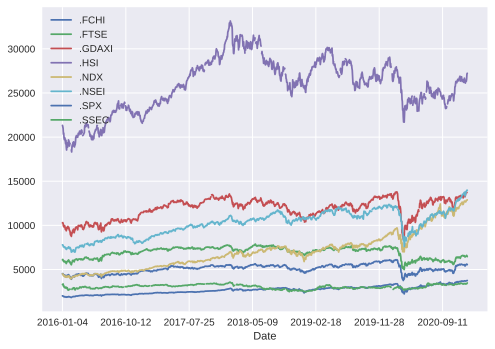

In [17]:
raw.plot();

## Define the investable universe 

In [20]:
universe = raw.columns
universe

Index(['.FCHI', '.FTSE', '.GDAXI', '.HSI', '.NDX', '.NSEI', '.SPX', '.SSEC'], dtype='object')

## Define a Class to implement Mean-Variance Porfolio

In [279]:
class MVP:
    url = 'https://hilpisch.com/indices_eikon_eod_data.csv'

    def __init__(self, universe, weights='equal'):
        self.universe = universe
        self.retrieve_data()
        self.prepare_data()
        self.weights = weights
        # self.random_weights()
    
    def retrieve_data(self):
        self.raw = pd.read_csv(self.url, index_col=0, parse_dates=True)
        self.raw.dropna(inplace=True)

    def prepare_data(self):
        if self.universe is None:
            self.data = self.raw
            self.universe = self.data.columns
        else:
            self.data = self.raw[self.universe]
        
        self.no_assets = len(self.universe)
        self.rets = np.log(self.data / self.data.shift(1)).dropna()
        # self.rets.dropna(inplace=True)
    
    def portfolio_weights(self):
        if self.weights == 'equal':
            self.equal_weights = np.array(self.no_assets * [1 / self.no_assets])
            return self.equal_weights
        else:
            np.random.seed(2025)
            self.random_weights = np.random.random(self.no_assets)
            self.random_weights /= self.random_weights.sum()
            return self.random_weights
    
    def portfolio_return(self, weights, days=252):
        return np.dot(self.rets.mean(), weights) * days
    
    def portfolio_variance(self, weights, days=252):
        return np.dot(weights, np.dot(self.rets.cov(), weights)) * days
    
    def portfolio_volatility(self, weights, days=252):
        return np.sqrt(self.portfolio_variance(weights, days))
    
    def portfolio_Sharpe(self, weights, days=252):
        Sharpe = (self.portfolio_return(weights, days) / self.portfolio_volatility(weights, days))
        return Sharpe
    
    def _set_bounds_constraints(self, bnds, cons):
        if bnds is None:
            self.bnds = self.no_assets * [(0, 1)]
        else:
            self.bnds = bnds
        if cons is None:
            self.cons = {'type': 'eq', 'fun': lambda weights: weights.sum() - 1}
        else:
            self.cons = cons
    
    def _get_results(self, opt, kind):
        ret = self.portfolio_return(opt['x'])
        vol = self.portfolio_volatility(opt['x'])
        Sharpe = self.portfolio_Sharpe(opt['x'])
        weights = pd.DataFrame(opt['x'], index=self.universe, columns=['weights',])
        res = {'kind': kind, 'weights': weights.round(7), 'return': ret,
               'volatility': vol, 'Sharpe': Sharpe}
        return res
    
    def minimum_volatility_portfolio(self, bnds=None, cons=None):
        self._set_bounds_constraints(bnds, cons)
        if self.weights == 'equal':
            opt = minimize(self.portfolio_volatility, self.equal_weights,
                           bounds=self.bnds, constraints=self.cons)
        else:
            opt = minimize(self.portfolio_volatility, self.random_weights,
                           bounds=self.bnds, constraints=self.cons)
        self.results = self._get_results(opt, 'Minimum Volatility')
        return self.results
    
    def maximum_Sharpe_portfolio(self, bnds=None, cons=None):
        self._set_bounds_constraints(bnds, cons)
        tf = lambda weights: -self.portfolio_Sharpe(weights)
        if self.weights == 'equal':
            opt = minimize(tf, self.equal_weights, bounds=self.bnds,
                           constraints=self.cons)
        else:
            opt = minimize(tf, self.random_weights, bounds=self.bnds,
                           constraints=self.cons)
        self.results = self._get_results(opt, 'Maximum Sharpe')
        return self.results

    def value_at_risk(self, weights, rets, percs=None):
        r = np.dot(rets, weights)
        if percs is None:
            percs = [0.01, 0.1, 1., 2.5, 5.0, 10.0]
        var = scs.scoreatpercentile(r, percs)
        v = list()
        for pair in zip(percs, var):
            v.append((100 - pair[0], -pair[1]))
        df = pd.DataFrame(v, columns=['ConfLev', 'VaR'])
        df.set_index('ConfLev', inplace=True)
        return df

    def expected_shortfall(self, weights, rets, percs=None):
        r = np.dot(rets, weights)
        if percs is None:
            percs = [0.01, 0.1, 1., 2.5, 5.0, 10.0]
        var = scs.scoreatpercentile(r, percs)
        v = list()
        for pair in zip(percs, var):
            es = r[r < pair[1]].mean()
            v.append((100 - pair[0], -pair[1], -es))
        df = pd.DataFrame(v, columns=['ConfLev', 'VaR', 'ES'])
        df.set_index('ConfLev', inplace=True)
        return df
    
    def simulated_frontier(self):
        np.random.seed(2025)
        rr = []
        rv = []
        for i in range(3000):            
            rw = np.random.random(len(universe))
            rw /= np.sum(rw)
            rr.append(mvp_ew.portfolio_return(rw))
            rv.append(mvp_ew.portfolio_volatility(rw))
            
        sf = pd.DataFrame({'Returns': rr, 'Volatility': rv})
        sf.plot.scatter(x="Volatility", y="Returns", style="*");
        plt.plot(mvp_ew.maximum_Sharpe_portfolio(bnds=mvp_ew.no_assets*[(0, 1)])['volatility'],
                 mvp_ew.maximum_Sharpe_portfolio(bnds=mvp_ew.no_assets*[(0, 1)])['return'],
                 'r^', ms=12.5, label='max Sharpe');
        plt.plot(mvp_ew.minimum_volatility_portfolio(bnds=mvp_ew.no_assets*[(0, 1)])['volatility'],
                 mvp_ew.minimum_volatility_portfolio(bnds=mvp_ew.no_assets*[(0, 1)])['return'],
                 'gv', ms=12.5, label='min Volatility');
        plt.legend(loc='best');
        plt.title('Simulated Frontier')
    
    
    def plot_data(self, cols=None):
        if cols is None:
            cols = self.universe
        self.data[cols].plot()
        
    def plot_corr(self):
        # plotting correlation matrix
        plt.imshow(self.rets.corr(), cmap='RdYlBu')
        plt.colorbar()
        plt.xticks(range(len(self.rets.corr())), self.universe, rotation=45, ha='right')
        plt.yticks(range(len(self.rets.corr())), self.universe)
            
    def plot_weights(self, kind='pie'):
        if kind == 'pie':
            nonzero = self.results['weights'] > 0
            to_plot = self.results['weights'][nonzero['weights']].copy()
            to_plot['names'] = to_plot.index
            plt.pie(to_plot['weights'], labels=to_plot['names'],
                    explode=(to_plot['weights']), shadow=True, startangle=90)
            
        else:
            self.results['weights'].plot(kind='bar',
                    title='Optimal Weights | ' + self.results['kind'])
            
    
    def plot_performance(self):
        perf = (self.results['return'], self.results['volatility'], self.results['Sharpe'])
        index = ['return', 'volatility', 'Sharpe']
        to_plot = pd.DataFrame(perf, index=index, columns=['metrics',])
        to_plot.plot(kind='bar', title='Performance Metrics  | ' + self.results['kind'])


### Instantiate Mean-Variance Portfolio Class

In [282]:
mvp_ew = MVP(universe, weights='equal') # weights options are 'equal' or 'random'

In [283]:
mvp_ew.weights

'equal'

In [286]:
mvp_ew.portfolio_weights()

array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125])

### Portfolio Performance with equal asset weights

In [289]:
mvp_ew.portfolio_return(mvp_ew.portfolio_weights())

0.09017424970739357

In [291]:
mvp_ew.portfolio_volatility(mvp_ew.portfolio_weights())

0.1542818629909288

In [293]:
mvp_ew.portfolio_variance(mvp_ew.portfolio_weights())

0.02380289324795173

In [295]:
mvp_ew.portfolio_Sharpe(mvp_ew.portfolio_weights())

0.5844773193638159

### Portfolio Performance with random asset weights

In [298]:
mvp_rw = MVP(universe, weights='random')

In [299]:
mvp_rw.weights

'random'

In [302]:
mvp_rw.portfolio_weights()

array([0.0323, 0.2115, 0.2222, 0.1062, 0.0925, 0.0614, 0.1566, 0.1174])

In [304]:
mvp_rw.portfolio_return(mvp_rw.portfolio_weights())

0.08039323974022415

In [306]:
mvp_rw.portfolio_volatility(mvp_rw.portfolio_weights())

0.15776020844716507

In [308]:
mvp_rw.portfolio_Sharpe(mvp_rw.portfolio_weights())

0.5095913635734601

### Minimum Volatility Portfolio

In [311]:
mvp_ew.minimum_volatility_portfolio()

{'kind': 'Minimum Volatility',
 'weights':         weights
 .FCHI    0.0000
 .FTSE    0.1921
 .GDAXI   0.0000
 .HSI     0.0290
 .NDX     0.0000
 .NSEI    0.2118
 .SPX     0.2318
 .SSEC    0.3353,
 'return': 0.06970258472591692,
 'volatility': 0.14132155004153846,
 'Sharpe': 0.49321978640504105}

### Maximum Sharpe Ratio Portfolio

#### Does not allow for Short positions

In [315]:
mvp_ew.maximum_Sharpe_portfolio(bnds=mvp_ew.no_assets*[(0, 1)])

{'kind': 'Maximum Sharpe',
 'weights':         weights
 .FCHI    0.0000
 .FTSE    0.0000
 .GDAXI   0.0000
 .HSI     0.0000
 .NDX     0.6462
 .NSEI    0.3538
 .SPX     0.0000
 .SSEC    0.0000,
 'return': 0.20573235794413347,
 'volatility': 0.1814364161131807,
 'Sharpe': 1.133908850006147}

#### with Short positions

In [318]:
mvp_ew.maximum_Sharpe_portfolio(bnds=mvp_ew.no_assets*[(-0.1, 1)])

{'kind': 'Maximum Sharpe',
 'weights':         weights
 .FCHI   -0.1000
 .FTSE   -0.1000
 .GDAXI  -0.1000
 .HSI    -0.0969
 .NDX     0.9279
 .NSEI    0.6690
 .SPX    -0.1000
 .SSEC   -0.1000,
 'return': 0.2833310077229365,
 'volatility': 0.21808558617705692,
 'Sharpe': 1.2991734698730106}

#### No Short positions and min 5% in asset

In [321]:
mvp_ew.maximum_Sharpe_portfolio(bnds=mvp_ew.no_assets*[(0.05, 1)])

{'kind': 'Maximum Sharpe',
 'weights':         weights
 .FCHI    0.0500
 .FTSE    0.0500
 .GDAXI   0.0500
 .HSI     0.0500
 .NDX     0.5393
 .NSEI    0.1607
 .SPX     0.0500
 .SSEC    0.0500,
 'return': 0.1704799819898897,
 'volatility': 0.17380035450615783,
 'Sharpe': 0.9808954790356859}

In [323]:
mvp_rw.maximum_Sharpe_portfolio(bnds=mvp_rw.no_assets*[(0.05, 1)])

{'kind': 'Maximum Sharpe',
 'weights':         weights
 .FCHI    0.0500
 .FTSE    0.0500
 .GDAXI   0.0500
 .HSI     0.0500
 .NDX     0.5399
 .NSEI    0.1601
 .SPX     0.0500
 .SSEC    0.0500,
 'return': 0.17055198311234251,
 'volatility': 0.17387383157808467,
 'Sharpe': 0.9808950637620799}

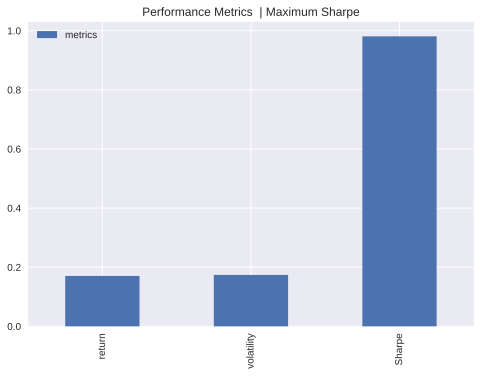

In [325]:
mvp_ew.plot_performance()

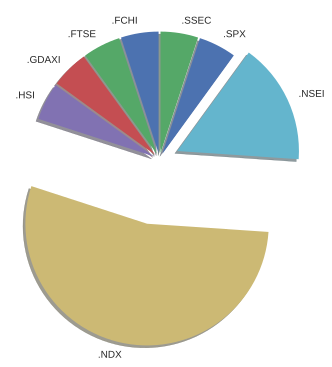

In [327]:
mvp_ew.plot_weights(kind='pie')

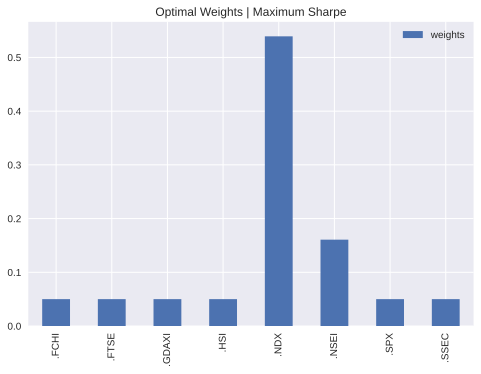

In [329]:
mvp_ew.plot_weights(kind='bar')

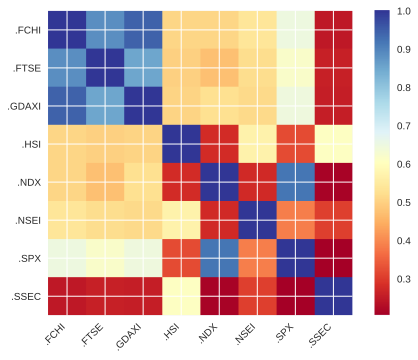

In [330]:
mvp_ew.plot_corr();

In [332]:
mvp_ew.value_at_risk(mvp_ew.equal_weights, mvp_ew.rets)

,VaR
ConfLev,
99.9900,0.0872
99.9000,0.0705
99.0000,0.0350
97.5000,0.0200
95.0000,0.0125
90.0000,0.0084


In [335]:
mvp_ew.expected_shortfall(mvp_ew.equal_weights, mvp_ew.rets)

,VaR,ES
ConfLev,,
99.9900,0.0872,0.0891
99.9000,0.0705,0.0800
99.0000,0.0350,0.0488
97.5000,0.0200,0.0347
95.0000,0.0125,0.0253
90.0000,0.0084,0.0179


In [337]:
np.shape(mvp_ew.equal_weights)

(8,)

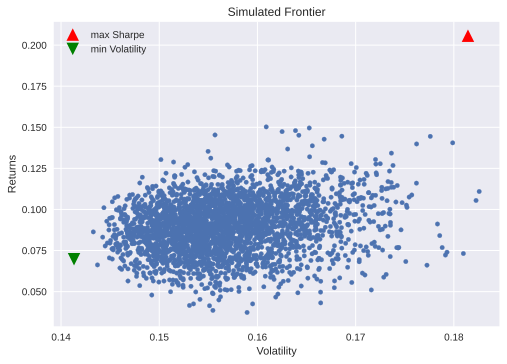

In [339]:
mvp_ew.simulated_frontier()

In [205]:
mvp_ew.portfolio_volatility(mvp_ew.equal_weights)

0.1542818629909288

In [207]:
mvp_rw.maximum_Sharpe_portfolio(bnds=mvp_rw.no_assets*[(0.05, 1)])['return']

0.1704638062911976

In [209]:
mvp_ew.portfolio_return(mvp_ew.equal_weights)

0.09017424970739357